In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans


In [14]:
sq_distances = np.arange(10)
new_sq_distances = np.arange(10,20)
new_cost = np.sum(np.minimum(sq_distances, new_sq_distances))
new_cost


45

In [15]:
class KMeansClustering:
    def __init__(self, n_clusters=8, max_iter=300, tol=0.0001, random_state=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def _greedy_kmeans_plus_plus(self, X): #вся эта функция устанавливает начальное приближение для центров кластеров
        np.random.seed(self.random_state) #устанавливаем сид
        n_samples, n_features = X.shape #запоминаем количество объектов и количество признаков
        n_local_trials = 2 + int(np.log(self.n_clusters)) #Гарантированное число итераций для поиска одного центра

        indices = np.arange(n_samples) #индексы по количеству объектов
        first_index = np.random.choice(indices) #рандомно выбираем первый объект
        centers = np.zeros((self.n_clusters, n_features)) #инициализируем все центры нулями

        centers[0] = X[first_index] #закидваем первый центр в рандомный объект исходной выборки
        first_center = centers[0].reshape(1, -1)
        sq_distances = cdist(X, first_center, metric='sqeuclidean').ravel() #считаем расстояние от каждого объекта до первого центра

        for i in range(1, self.n_clusters): #в цикле по всем кластерам - находим наилучший центр для каждого кластера
            min_cost = np.inf
            min_new_sq_distances = []
            best_candidate_index = None

            for _ in range(n_local_trials):
                candidates_probas = sq_distances / np.sum(sq_distances) #вероятности кандидатов пропорциональные квадрату расстояния
                candidate_index = np.random.choice(indices, p=candidates_probas) #выбираем одного кандидата с заданной вероятностью
                candidate = X[candidate_index].reshape(1, -1) 

                new_sq_distances = cdist(X, candidate, metric='sqeuclidean').ravel() #пересчитали расстояния до этого кандидата
                new_cost = np.sum(np.minimum(sq_distances, new_sq_distances)) #высчитали сумму минимальных расстояний объектов

                if new_cost < min_cost:
                    best_candidate_index = candidate_index
                    min_new_sq_distances = new_sq_distances
                    min_cost = new_cost

            centers[i] = X[best_candidate_index]   # Choose the new center
            sq_distances = np.minimum(sq_distances, min_new_sq_distances)

        return centers

    def fit(self, X): #обучение
        n_samples, n_features = X.shape
        self.inertia_ = np.inf
        self.cluster_centers_ = self._greedy_kmeans_plus_plus(X) #инициализация центров кластеров

        # Lloyd's algorithm
        for _ in range(self.max_iter):
            distances = cdist(X, self.cluster_centers_, metric='sqeuclidean') #посчитали расстояния от каждого объекта до всех центроид
            labels = np.argmin(distances, axis=1) #указываем ближайший центроид для каждого объекта
            new_inertia = np.sum(np.min(distances, axis=1)) #сумма минимальных расстояний 
            new_centers = np.zeros((self.n_clusters, n_features)) #подготовка новых центров

            for k in range(self.n_clusters):
                new_centers[k] = np.mean(X[labels == k], axis=0) #пересчет центров через средн.арифм (формлуа центра масс)

            if np.abs(new_inertia - self.inertia_) < self.tol: #проверка критерия
                break

            self.inertia_ = new_inertia
            self.cluster_centers_ = new_centers

    def predict(self, X):
        distances = cdist(X, self.cluster_centers_, metric='sqeuclidean')
        predicted_labels = np.argmin(distances, axis=1)

        return predicted_labels

In [16]:
X1, y1 = make_blobs(n_samples=250, n_features=2, centers=8, random_state=0)
print(y1)
print(X1)

# [1 3 7 7 6 7 1 3 7 7 0 3 1 1 3 3 5 1 7 4 0 1 1 3 4 7 0 0 6 7 0 0 5 5 7 2 1
#  1 6 5 4 7 1 2 1 1 4 3 6 4 7 3 0 2 2 1 7 2 4 0 0 0 1 4 6 5 0 4 6 6 4 4 1 4
#  2 3 1 1 5 4 6 4 1 2 5 0 7 6 7 3 0 1 2 5 1 5 3 3 3 1 5 4 0 4 7 6 2 2 2 4 6
#  2 5 1 6 4 0 6 5 0 0 6 3 5 1 6 0 2 5 5 6 3 3 1 5 4 5 0 2 2 3 0 4 7 5 4 2 0
#  2 6 2 5 2 1 4 1 5 0 4 6 7 5 5 7 6 2 2 3 6 1 7 3 4 7 2 6 6 4 2 2 0 5 4 4 6
#  3 1 7 6 7 7 0 4 5 7 2 6 6 2 5 3 3 2 7 1 7 6 6 4 3 5 7 6 3 5 0 3 3 5 5 2 0
#  6 3 4 0 5 3 5 2 0 6 4 0 1 1 2 2 0 1 3 7 0 7 0 3 4 7 3 7]

[1 3 7 7 6 7 1 3 7 7 0 3 1 1 3 3 5 1 7 4 0 1 1 3 4 7 0 0 6 7 0 0 5 5 7 2 1
 1 6 5 4 7 1 2 1 1 4 3 6 4 7 3 0 2 2 1 7 2 4 0 0 0 1 4 6 5 0 4 6 6 4 4 1 4
 2 3 1 1 5 4 6 4 1 2 5 0 7 6 7 3 0 1 2 5 1 5 3 3 3 1 5 4 0 4 7 6 2 2 2 4 6
 2 5 1 6 4 0 6 5 0 0 6 3 5 1 6 0 2 5 5 6 3 3 1 5 4 5 0 2 2 3 0 4 7 5 4 2 0
 2 6 2 5 2 1 4 1 5 0 4 6 7 5 5 7 6 2 2 3 6 1 7 3 4 7 2 6 6 4 2 2 0 5 4 4 6
 3 1 7 6 7 7 0 4 5 7 2 6 6 2 5 3 3 2 7 1 7 6 6 4 3 5 7 6 3 5 0 3 3 5 5 2 0
 6 3 4 0 5 3 5 2 0 6 4 0 1 1 2 2 0 1 3 7 0 7 0 3 4 7 3 7]
[[  2.43169305  -0.20173713]
 [ -1.10630261   7.5161316 ]
 [ -9.01846836  -8.07607558]
 [ -9.09679788  -9.23624387]
 [  2.18247693   8.51722541]
 [ -8.92672949  -8.83868248]
 [  3.54351972   2.79355284]
 [ -2.19270203   7.42541032]
 [ -8.11614851  -7.97831824]
 [-10.21191336  -9.82518173]
 [  3.2460247    2.84942165]
 [ -1.71185175   8.31694149]
 [  0.9845149    1.95211539]
 [  2.3535057    2.22404956]
 [ -0.55671702   8.53020916]
 [ -1.26527619   8.21461175]
 [  4.07861018   1.02883286]

In [18]:
kmeans = KMeansClustering(n_clusters=8, random_state=0)
kmeans.fit(X1)
kmeans_pred_res = kmeans.predict(X1)
kmeans_ari = adjusted_rand_score(y1, kmeans_pred_res)
kmeans_centroinds = kmeans.cluster_centers_
print(f'Adjusted Rand Score for KMeans: {kmeans_ari}', '', sep='\n')
print('centroids', kmeans_centroinds, '', sep='\n')
print('prediction', kmeans_pred_res, sep='\n')

Adjusted Rand Score for KMeans: 0.8082423809657193

centroids
[[ 9.20217726 -2.23709633]
 [-1.5438023   7.64224793]
 [-8.61527648 -8.32916569]
 [ 0.81231976  4.02302811]
 [-1.81106448  2.87987747]
 [ 2.3666746   1.30457024]
 [ 1.47433518  8.49698324]
 [ 5.86512606  0.19818122]]

prediction
[5 1 2 2 6 2 5 1 2 2 5 1 5 5 1 1 5 5 2 0 3 7 3 1 0 2 3 3 6 2 1 3 7 7 2 4 5
 5 6 7 0 2 5 4 5 5 0 1 6 7 2 1 3 3 4 5 2 4 0 3 3 3 5 0 6 7 3 0 6 6 0 0 5 0
 3 1 5 5 7 0 3 0 5 4 7 3 2 6 2 6 3 5 4 5 5 7 1 1 1 3 7 0 3 0 2 6 3 4 4 0 6
 4 7 5 1 0 3 6 7 3 3 6 1 7 5 6 3 4 7 7 6 1 1 5 7 0 7 3 4 4 1 3 0 2 7 0 4 3
 4 6 4 7 4 5 0 5 7 3 0 6 2 7 5 2 6 4 3 3 6 5 2 1 0 2 4 6 6 0 4 4 3 7 0 0 6
 1 5 2 6 2 2 3 0 7 2 4 6 6 4 7 1 1 4 2 5 2 6 1 0 1 5 2 6 6 7 3 1 1 7 7 4 3
 6 1 0 3 7 1 7 4 4 6 0 3 5 5 4 4 3 3 1 2 3 2 3 1 0 2 1 2]


In [17]:
sk_kmeans = KMeans(n_clusters=8, n_init='auto', random_state=0)
sk_kmeans.fit(X1)
sk_kmeans_pred_res = sk_kmeans.predict(X1)
sk_kmeans_ari = adjusted_rand_score(y1, sk_kmeans_pred_res)
sk_kmeans_centroinds = sk_kmeans.cluster_centers_
print(f'Adjusted Rand Score for sk KMeans: {sk_kmeans_ari}', '', sep='\n')
print(sk_kmeans_centroinds, '', sep='\n')
print('prediction', sk_kmeans_pred_res, sep='\n')

Adjusted Rand Score for sk KMeans: 0.8082423809657193

[[ 9.20217726 -2.23709633]
 [-1.5438023   7.64224793]
 [-8.61527648 -8.32916569]
 [ 0.81231976  4.02302811]
 [-1.81106448  2.87987747]
 [ 2.3666746   1.30457024]
 [ 1.47433518  8.49698324]
 [ 5.86512606  0.19818122]]

prediction
[5 1 2 2 6 2 5 1 2 2 5 1 5 5 1 1 5 5 2 0 3 7 3 1 0 2 3 3 6 2 1 3 7 7 2 4 5
 5 6 7 0 2 5 4 5 5 0 1 6 7 2 1 3 3 4 5 2 4 0 3 3 3 5 0 6 7 3 0 6 6 0 0 5 0
 3 1 5 5 7 0 3 0 5 4 7 3 2 6 2 6 3 5 4 5 5 7 1 1 1 3 7 0 3 0 2 6 3 4 4 0 6
 4 7 5 1 0 3 6 7 3 3 6 1 7 5 6 3 4 7 7 6 1 1 5 7 0 7 3 4 4 1 3 0 2 7 0 4 3
 4 6 4 7 4 5 0 5 7 3 0 6 2 7 5 2 6 4 3 3 6 5 2 1 0 2 4 6 6 0 4 4 3 7 0 0 6
 1 5 2 6 2 2 3 0 7 2 4 6 6 4 7 1 1 4 2 5 2 6 1 0 1 5 2 6 6 7 3 1 1 7 7 4 3
 6 1 0 3 7 1 7 4 4 6 0 3 5 5 4 4 3 3 1 2 3 2 3 1 0 2 1 2]


C:\Users\Danil\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


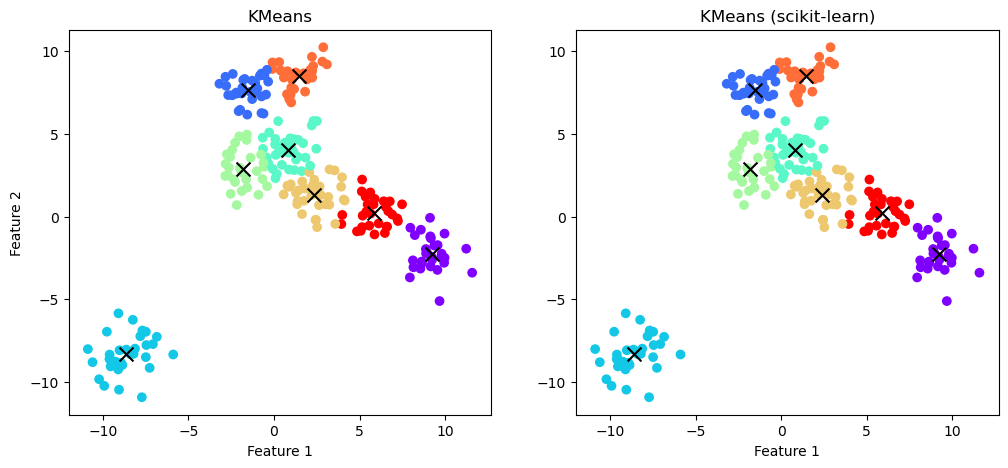

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.2)
plt.scatter(X1[:, 0], X1[:, 1], c=kmeans_pred_res, cmap="rainbow")
plt.scatter(kmeans_centroinds[:, 0], kmeans_centroinds[:, 1], marker="x", color="black", s=100)
plt.title("KMeans")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.subplots_adjust(wspace=0.2)
plt.scatter(X1[:, 0], X1[:, 1], c=sk_kmeans_pred_res, cmap="rainbow")
plt.scatter(sk_kmeans_centroinds[:, 0], sk_kmeans_centroinds[:, 1], marker="x", color="black", s=100)
plt.title("KMeans (scikit-learn)")
plt.xlabel("Feature 1")

plt.show()